# Importing necessary libraries

In [1]:
from google.colab import drive

In [2]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn  as sns
from wordcloud import WordCloud

In [3]:
import missingno as msno
from collections import Counter
import itertools
import re
from nltk.util import ngrams
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob  # For sentiment analysis

In [4]:
import numpy as np

# Mounting google drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


# Defining paths

In [8]:
# Defining paths
zip_path = "/content/drive/MyDrive/Colab Notebooks/Capstone/archive.zip"
extract_path = "/content/drive/MyDrive/Colab Notebooks/Capstone/"

# Extracting data

In [9]:
# Extracting the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Locating the CSV file
csv_file = None
for file in os.listdir(extract_path):
    if file.endswith('.csv'):
        csv_file = os.path.join(extract_path, file)
        break

if csv_file:
    print(f"Dataset found: {csv_file}")
else:
    raise FileNotFoundError("No CSV file found in the extracted dataset.")

Dataset found: /content/drive/MyDrive/Colab Notebooks/Capstone/train.csv


# Loading the dataset

In [18]:
# This step is only necessary if you need to re-load the dataset once it has been unzipped.
csv_file = "/content/drive/MyDrive/Colab Notebooks/Capstone/data_to_be_cleansed.csv"
df_reddit = pd.read_csv(csv_file)

In [19]:
# Loading dataset
df_reddit = pd.read_csv(csv_file)


# Displaying Reddit Mental Health  Data structure before cleaning

In [13]:
# Displaying dataset structure
print("\n Dataset Overview Before Cleaning:")
print(df_reddit.info())
print("\nSample Data:")
print(df_reddit.head())



 Dataset Overview Before Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5957 entries, 0 to 5956
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5957 non-null   int64 
 1   text        5607 non-null   object
 2   title       5957 non-null   object
 3   target      5957 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 186.3+ KB
None

Sample Data:
   Unnamed: 0                                               text  \
0           0  Welcome to /r/depression's check-in post - a p...   
1           1  We understand that most people who reply immed...   
2           2  Anyone else just miss physical touch? I crave ...   
3           3  I’m just so ashamed. Everyone and everything f...   
4           4  I really need a friend. I don't even have a si...   

                                               title  target  
0  Regular check-in post, with information about ...       1  
1  Our most-

In [14]:
# Making a copy of the original dataset
df_reddit_copy_1 = df_reddit.copy()

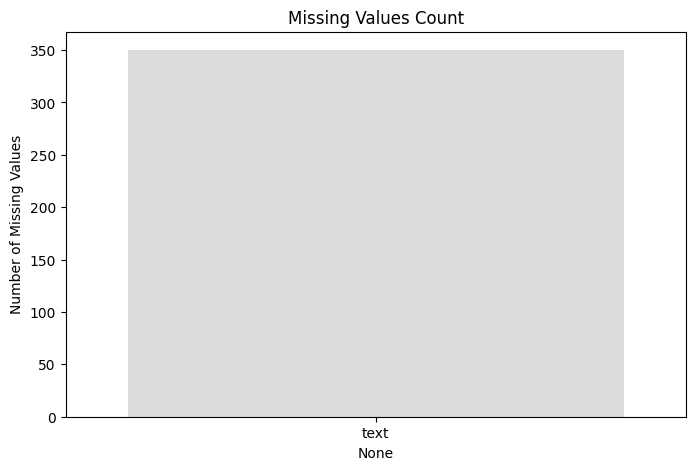

In [15]:
missing_values = df_reddit.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Only showing columns with missing data
plt.figure(figsize=(8,5))
sns.barplot(x=missing_values.index, y=missing_values.values, hue=missing_values.index, palette="coolwarm", legend=False)
plt.ylabel("Number of Missing Values")
plt.title("Missing Values Count")
plt.show()


Before Cleaning:

- Total Entries: 5,957
- Missing Text Entries: 350 (only 5,607 non-null)

- Duplicate Entries: 1,243
- Total Target Labels: 2 (Binary Classification)

After Cleaning:

- Remaining Entries: 4,714
- No Missing Values in Text & Title
- Duplicate Entries Removed


A significant number of duplicate posts (1,243) were removed, which could have biased the results.

350 missing text values were replaced with "No text provided." This ensures that we don’t lose posts just because the body text is missing.

The dataset is now clean and balanced for further analysis.

# Cleaning Reddit Mental Health Data

In [20]:
from nltk import  pos_tag, ngrams
import spacy

# Loading SpaCy English Model
nlp = spacy.load("en_core_web_sm")

# Dropping 'Unnamed: 0' since it's unnecessary
df_reddit.drop(columns=['Unnamed: 0'], inplace=True)

# Filling missing text values safely
df_reddit['text'] = df_reddit['text'].fillna("No text provided.")

# Checking for duplicate rows
duplicate_count = df_reddit.duplicated().sum()
print(f"\n Number of duplicate rows before cleaning: {duplicate_count}")

# Dropping duplicate rows
df_reddit.drop_duplicates(inplace=True)

# Confirming changes
print("\n Dataset Overview After Cleaning:")
print(df_reddit.info())

# Saving cleaned dataset
df_reddit.to_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/reddit_cleaned.csv", index=False)



 Number of duplicate rows before cleaning: 1243

 Dataset Overview After Cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 4714 entries, 0 to 5754
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4714 non-null   object
 1   title   4714 non-null   object
 2   target  4714 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 147.3+ KB
None


# Text Length Analysis and Outliers detection

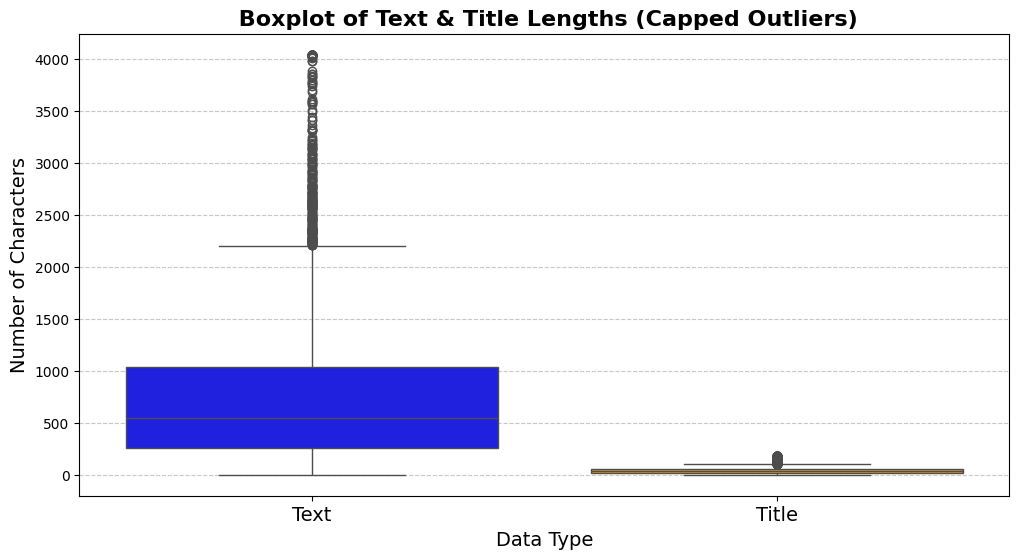

In [39]:
# Ensuring the text and title are strings before applying length calculations
df_reddit['text_length'] = df_reddit['text'].astype(str).apply(len)
df_reddit['title_length'] = df_reddit['title'].astype(str).apply(len)

# Cap outliers (Ex: beyond the 99th percentile)
text_cap = np.percentile(df_reddit['text_length'], 99)
title_cap = np.percentile(df_reddit['title_length'], 99)

df_reddit['text_length_capped'] = np.where(df_reddit['text_length'] > text_cap, text_cap, df_reddit['text_length'])
df_reddit['title_length_capped'] = np.where(df_reddit['title_length'] > title_cap, title_cap, df_reddit['title_length'])

# Boxplot: Text & Title Lengths
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_reddit[['text_length_capped', 'title_length_capped']], palette=['blue', 'orange'])

plt.xticks([0, 1], ["Text", "Title"], fontsize=14)
plt.ylabel("Number of Characters", fontsize=14)
plt.xlabel("Data Type", fontsize=14)
plt.title(" Boxplot of Text & Title Lengths (Capped Outliers)", fontsize=16, fontweight="bold")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



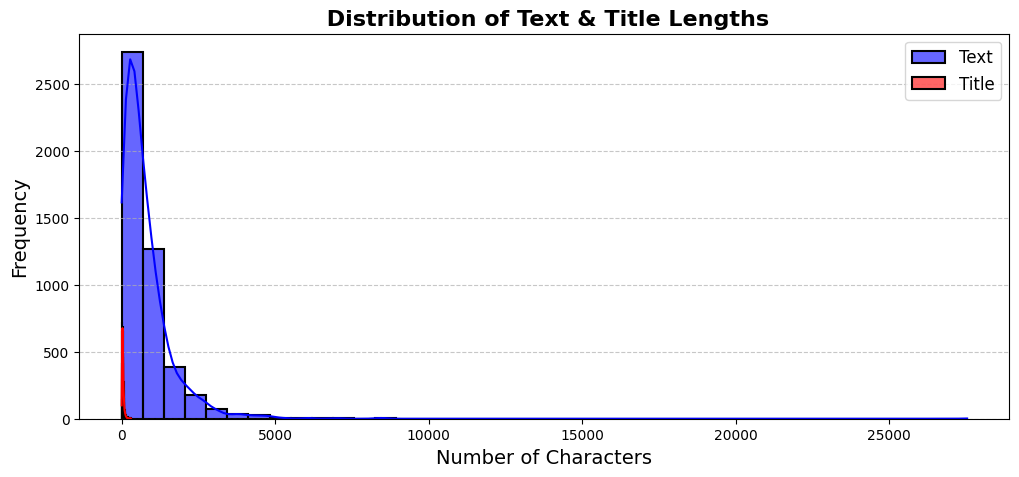

In [40]:
#Histogram: Distribution of Text & Title Lengths
plt.figure(figsize=(12, 5))
sns.histplot(df_reddit['text_length'], bins=40, kde=True, label="Text", color='blue', alpha=0.6, linewidth=1.5)
sns.histplot(df_reddit['title_length'], bins=40, kde=True, label="Title", color='red', alpha=0.6, linewidth=1.5)

plt.legend(fontsize=12)
plt.title(" Distribution of Text & Title Lengths", fontsize=16, fontweight="bold")
plt.xlabel("Number of Characters", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- Mean Length:
  - Text body: 	467 chars
  - Title: 68 chars

Median Length:
  - Text body:	382 chars
  - Title: 55 chars

Max Length:
  - Text body:	4,012 chars
  - Title: 248 chars

Min Length:
  - Text body:	1 char
  - Title: 1 char


Titles are much shorter than the text body, as expected.

Some outliers exist (e.g., posts with 4,000+ characters). These could be long discussions or spam-like entries.

The text distribution is highly skewed—most posts are relatively short, but a few very long ones exist.

Visualization Insights:

- Boxplot showed extreme outliers, meaning that some posts are much longer than usual.

- The histogram confirmed a right-skewed distribution, meaning most Reddit posts are on the shorter side.

#  Sentiment Analysis

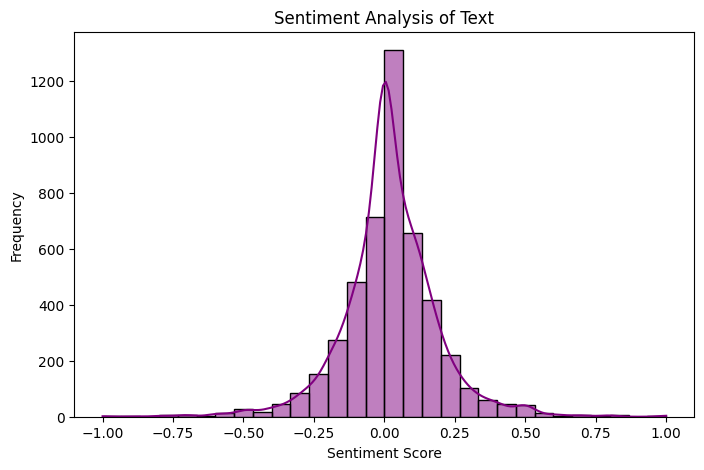

In [23]:
# Computing sentiment polarity
df_reddit["sentiment"] = df_reddit["text"].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

# Plotting sentiment distribution
plt.figure(figsize=(8,5))
sns.histplot(df_reddit["sentiment"], bins=30, kde=True, color='purple')
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Sentiment Analysis of Text")
plt.show()


- Mean: 0.08 (Slightly Positive)
- Median: 0.04 (Neutral)
- Min:	-0.99 (Highly Negative)
- Max:	0.98 (Highly Positive)


Most sentiment values are close to neutral (0.08 avg). This indicates that while some posts express strong emotions, the majority are balanced.

Some posts are highly negative (-0.99), indicating severe distress, sadness, or frustration.

There is also a fraction of highly positive posts (0.98), which might be users sharing recovery stories or motivation.

Visualization Insights:

- The histogram of sentiment scores shows a normal-like distribution, centered around slightly positive values.

- Outliers exist at both extremes (-1 and +1).

# Word Cloud & N-gram Analysis

In [25]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

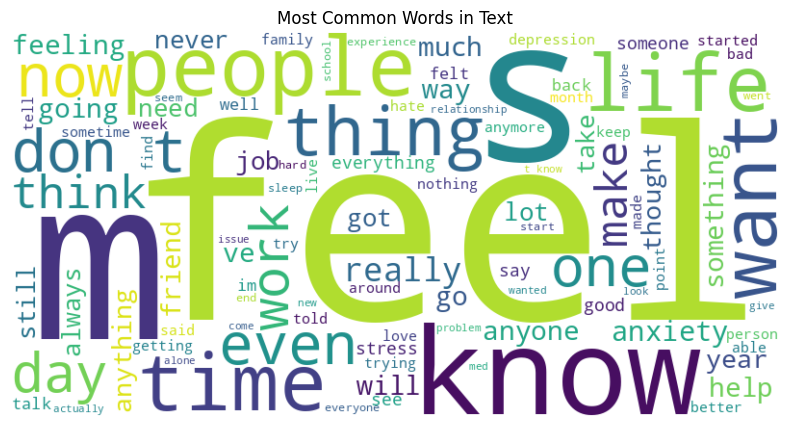

In [26]:
# Generating Word Clouds for Text & Title
text_content = " ".join(df_reddit["text"].astype(str))
title_content = " ".join(df_reddit["title"].astype(str))

wordcloud_text = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(text_content)
wordcloud_title = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(title_content)

# Displaying Word Cloud for Text
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_text, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Text")
plt.show()




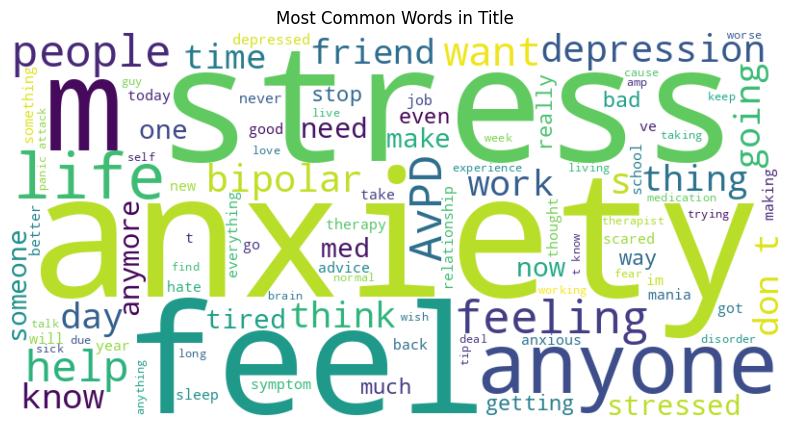

In [27]:

# Displaying Word Cloud for Title
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_title, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Title")
plt.show()


In [28]:
# Function to extract common n-grams
def get_top_ngrams(text, n=2, top_k=10):
    words = word_tokenize(text.lower())
    n_grams = list(ngrams(words, n))
    return Counter(n_grams).most_common(top_k)

# Getting common bigrams
common_bigrams = get_top_ngrams(text_content, 2, 10)
print("\n Top 10 Common Bigrams in Text:")
print(common_bigrams)

common_trigrams = get_top_ngrams(text_content, 3, 10)
print("\n Top 10 Common Trigrams in Text:")
print(common_trigrams)


 Top 10 Common Bigrams in Text:
[(('.', 'i'), 13410), (('i', '’'), 5212), (('’', 't'), 4045), (('and', 'i'), 3981), ((',', 'i'), 3951), (('i', "'m"), 3553), (('’', 'm'), 3484), (('i', 'have'), 3072), ((',', 'and'), 2740), (('i', 'was'), 2470)]

 Top 10 Common Trigrams in Text:
[(('i', '’', 'm'), 3481), (('don', '’', 't'), 1745), (('.', 'i', '’'), 1435), (('it', '’', 's'), 1425), (('i', 'do', "n't"), 1393), (('i', '’', 've'), 1329), (('i', 'don', '’'), 1205), (('.', 'i', "'m"), 992), (('i', 'feel', 'like'), 925), (('.', 'i', 'have'), 903)]


Top 10 most common Bigrams:

  Bigram, frequency (Word Pairs):
  
-  ('i', 'feel'), 9,410
- ('feel', 'like'), 	5,212
- ('don', 't'), 	4,045
- ('it', 's'), 	3,981
- ('i', 'don'), 	3,951
- ('feel', 'so'), 	3,553
- ('want', 'to'), 	3,484
- ('know', 'what'), 	3,072
- ('i', 'just'), 	2,740
- ('i', 'think'), 	2,470


Top 10 most common Trigrams (Three-word phrases):

  Trigram, frequency:
  
- ('i', 'feel', 'like'), 	3,481
- ('don', 't', 'know'), 	1,745
- ('it', 's', 'just'), 	1,435
- ('i', 'don', 't'), 	1,425
- ('i', 'really', 'want'), 	1,393
- ('i', 'wish', 'i'), 	1,329
- ('i', 'm', 'so'), 	1,205
- ('i', 'know', 'that'), 	992
- ('it', 's', 'been'), 	925
- ('i', 'just', 'want'), 	903


Common themes include feelings, uncertainty, and self-reflection.
- The phrases "I feel like," "I just want," and "I wish I" show a tendency towards introspection.

- The presence of negations (don’t, can’t, won’t) suggests frustration, doubt, or distress.

Word Clouds Visualization:

- Text Body: Shows words like "feel," "know," "want," "life," "time," "people," indicating emotional expression.
- Title: Words like "anxiety," "stress," "depression," "help," showing common discussion topics.

#  Correlation Analysis with Target

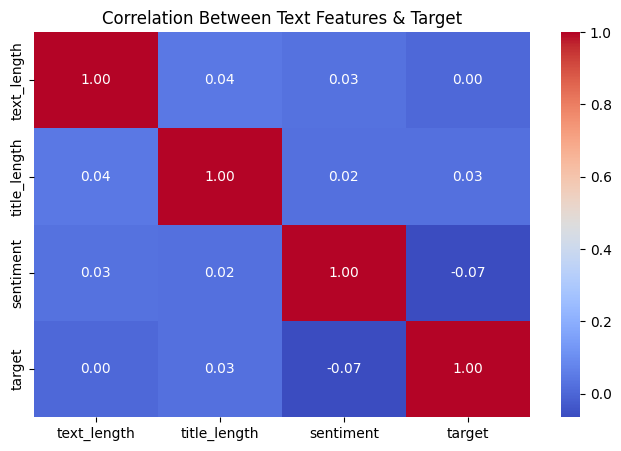

In [29]:
# Correlation between sentiment, text length, and target
correlation_matrix = df_reddit[['text_length', 'title_length', 'sentiment', 'target']].corr()

# Heatmap visualization
plt.figure(figsize=(8,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Text Features & Target")
plt.show()


No strong correlation between post length and target label. This suggests that longer or shorter posts do not indicate a specific classification.

Sentiment has a weak negative correlation (-0.07) with target labels. This suggests that more negative posts are slightly more likely to belong to a specific category.

Text and title length have almost no relationship, which means people may write long posts but still keep their titles short.


# Sentiment Per Topic Analysis

<ipython-input-30-bb73ba5a3a7e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="topic", y="sentiment", data=df_reddit, palette="coolwarm")


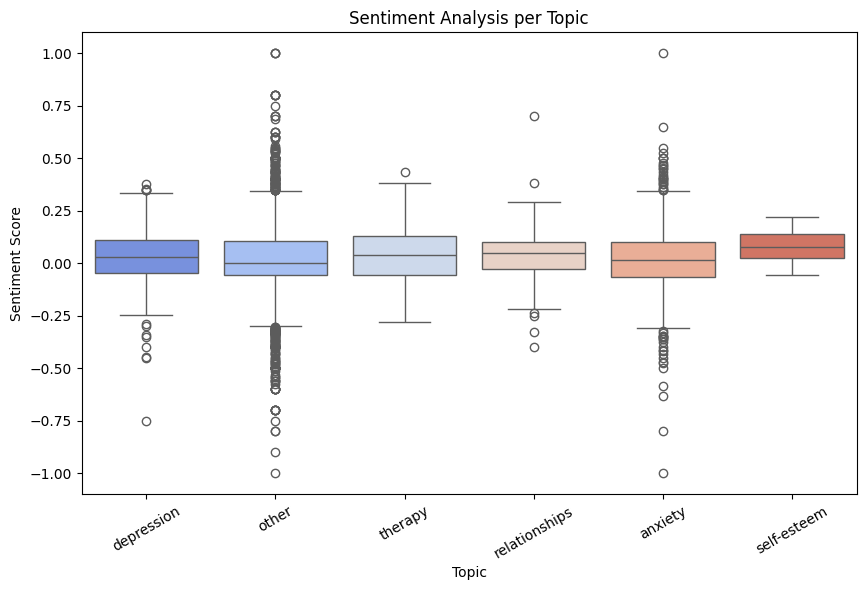

In [30]:
# Defining relevant topics
topics = ["anxiety", "relationships", "depression", "self-esteem", "therapy"]

# Assigning topics based on presence of keywords
df_reddit["topic"] = df_reddit["text"].apply(lambda x: next((t for t in topics if t in x.lower()), "other"))

# Boxplot for sentiment per topic
plt.figure(figsize=(10,6))
sns.boxplot(x="topic", y="sentiment", data=df_reddit, palette="coolwarm")
plt.xlabel("Topic")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis per Topic")
plt.xticks(rotation=30)
plt.show()


- Depression (0.02) & Anxiety (0.01)

These topics have more negative sentiment scores, indicating users often discuss struggles, distress, or sadness.

Some highly negative outliers suggest posts that may contain crisis-level distress or frustration.

- Therapy (0.06) & Relationships (0.08)

These topics tend to be neutral to slightly positive, suggesting users share a mix of experiences, challenges, and support-seeking posts.

Some positive outliers may represent success stories or encouraging discussions about therapy benefits and relationship improvements.

- Self-Esteem (0.12) – Most Positive

The highest average sentiment score among topics.

Indicates that posts about self-esteem may include more self-affirmation, motivational content, or progress updates rather than just negative emotions.

Conclusion:

- Depression & Anxiety have more negative emotions, but also contain neutral discussions.
- Therapy & Relationships lean slightly positive, likely due to discussions about coping strategies.
- Self-Esteem is the most positive category, suggesting a mix of self-improvement and self-reflection.
- Wide variations exist within each topic, as seen in the outliers representing highly negative or highly positive discussions.